# 黄金价格预测建模

## 数据预处理

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline

In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 13.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 导入数据，其中price代表黄金价格，rate代表美国十年期国债的实际收益率，VIX代表标准普尔500波动率指数，spread代表美债10年期收益率-2年期收益率利差，oilprice代表原油期货合约价格
price = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/gold_price.xlsx')
rate = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/real_interest_rate.xlsx')
VIX = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/VIX.xlsx')
spread = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/spread.xlsx')
oilprice = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/oilprice.xlsx')
ratio = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ratio.xlsx')
unemployment = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/unemployment.xlsx')

In [ ]:
set1 = set(rate['Date'])
set2 = set(VIX['Date'])
set3 = set(price['Date'])
set4 = set(spread['Date'])
set5 = set(oilprice['Date'])
set6 = set(ratio['Date'])
set7 = set(unemployment['Date'])
elements = set1.union(set2, set3, set4, set5, set6, set7)  # 将所有集合合并为一个集合
unique_elements = elements - set1.intersection(set2, set3, set4, set5, set6, set7)  # 找出不同时出现的元素
diff = list(unique_elements)  # 将结果转化为列表

In [ ]:
# 将数据集中不同时出现的元素删除，保持所有数据集对应的时间一致。
for i in diff:
    VIX_index = VIX.loc[VIX['Date'] == i].index
    VIX = VIX.drop(VIX_index)
    rate_index= rate.loc[rate['Date'] == i].index
    rate = rate.drop(rate_index)
    price_index= price.loc[price['Date'] == i].index
    price = price.drop(price_index)
    spread_index = spread.loc[spread['Date'] == i].index
    spread = spread.drop(spread_index)
    oilprice_index = oilprice.loc[oilprice['Date'] == i].index
    oilprice = oilprice.drop(oilprice_index)
    ratio_index = ratio.loc[ratio['Date'] == i].index
    ratio = ratio.drop(ratio_index)
    unemployment_index = unemployment.loc[unemployment['Date'] == i].index
    unemployment = unemployment.drop(unemployment_index)

In [ ]:
VIX.set_index('Date', inplace=True)
rate.set_index('Date', inplace=True)
price.set_index('Date', inplace=True)
spread.set_index('Date', inplace=True)
oilprice.set_index('Date', inplace=True)
ratio.set_index('Date', inplace=True)
unemployment.set_index('Date', inplace=True)

# 合并七个dataframe，Price, Rate, VIX, spread, oilprice
data = pd.concat([price['price'], rate['rate'], VIX['VIX'], spread['spread'], oilprice['oilprice'], ratio['ratio'], unemployment['unemployment']], axis=1)

In [ ]:
if data.isnull().values.any():
    print('数据集中存在缺失值')
else:
    print('数据集中不存在缺失值')

数据集中不存在缺失值


In [ ]:
# 选取建模所需的数据，调整不同的指标可以选择不同时间长度的数据来进行建模
data = data.loc['2013-01-01':'2023-06-12', ['price', 'rate', 'oilprice', 'VIX', 'spread', 'ratio']]
# 2022年至今的各项数据结果
data2022 = data.loc['2022-01-01':'2023-06-12', ['price', 'rate', 'oilprice', 'VIX', 'spread', 'ratio']]

## 时间序列预测分析模型

ARIMA（自回归积分滑动平均模型）是一种常用的时间序列预测模型，可以用于预测黄金价格或其他时间序列数据。ARIMA模型适用于具有一定的时间相关性和趋势性的数据。

ARIMA模型包括自回归（AR）、差分（I）和移动平均（MA）三个部分。通过对时间序列数据的差分操作，可以将非平稳序列转化为平稳序列，然后建立ARMA模型，最后再逆向差分得到预测结果。

使用ARIMA模型进行黄金价格预测时，需要进行以下步骤：

1.数据预处理：对黄金价格数据进行平稳性检验，如单位根检验（ADF检验）或差分操作，确保数据的平稳性。

2.模型训练：确定AR、I和MA的阶数（即模型的参数），可以通过观察自相关图（ACF）和偏自相关图（PACF）来进行初步选择，或使用信息准则（如AIC、BIC）进行模型选择。

3.模型拟合：使用训练集的数据拟合ARIMA模型，并进行参数估计。

4.模型诊断：对拟合后的模型进行诊断，包括残差分析、正态性检验、自相关性检验等，以评估模型的合理性和质量。

5.模型预测：使用训练好的ARIMA模型对测试集或未来时间的数据进行预测，得到黄金价格的预测结果。

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera

# 加载黄金价格数据
prices = data.loc['2018-01-01':'2023-05-01', ['price']]
test = data.loc['2023-05-01':'2023-06-12', ['price']]

# 进行ADF检验
result = adfuller(prices)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

# 进行JB检验
jb_statistic, p_value= jarque_bera(prices)

# 输出JB检验结果
print("JB统计量: ", jb_statistic)
print("P值: ", p_value)

# 进行差分操作
diff_prices = prices.diff().dropna()  # 一阶差分操作

# 再次进行ADF检验
result_diff = adfuller(diff_prices)
print('ADF Statistic (After differencing):', result_diff[0])
print('p-value (After differencing):', result_diff[1])
print('Critical Values (After differencing):')
for key, value in result_diff[4].items():
    print(f'{key}: {value}')

ADF Statistic: -0.8647460391317455
p-value: 0.7993603134498215
Critical Values:
1%: -3.4353440094155756
5%: -2.8637454499962196
10%: -2.5679441928400135
JB统计量:  129.03647268839748
P值:  9.551816564946412e-29
ADF Statistic (After differencing): -9.419429348306062
p-value (After differencing): 5.554559261467701e-16
Critical Values (After differencing):
1%: -3.4353440094155756
5%: -2.8637454499962196
10%: -2.5679441928400135


在进行ADF检验时，我们关注的是检验统计量（Test Statistic）与临界值（Critical Value）的比较。以下是对ADF检验结果的一般解释。具体来说，ADF检验的结果通常包括检验统计量、临界值和p值。一般来说，我们关注检验统计量与临界值之间的关系：

如果检验统计量小于临界值，且p值较小（通常小于0.05），则可以拒绝原假设，说明数据是平稳的。
如果检验统计量大于临界值，或者p值较大（通常大于0.05），则不能拒绝原假设，说明数据不是平稳的。

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


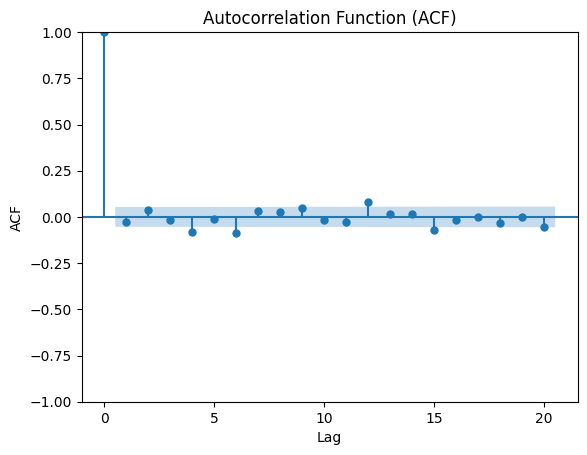

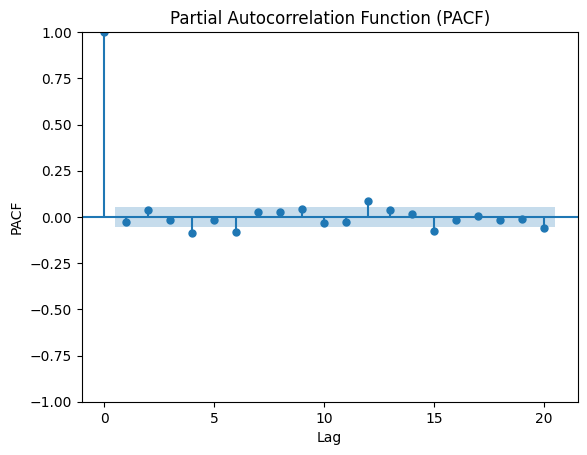

In [ ]:
# 绘制ACF图
plot_acf(diff_prices, lags=20)  # 设置lags参数为你希望显示的滞后阶数范围
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')

# 绘制PACF图
plot_pacf(diff_prices, lags=20)  # 设置lags参数为你希望显示的滞后阶数范围
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')

# 显示图形
plt.show()

In [ ]:
# 拟合ARIMA模型
model_arima = ARIMA(prices, order=(3, 1, 2))  # 设置ARIMA模型的阶数(p, d, q), 尝试多个不同的组合
model = model_arima.fit()

# 打印模型的AIC和BIC
# print("AIC:", model.aic)
# print("BIC:", model.bic)
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1328
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5533.410
Date:                Mon, 19 Jun 2023   AIC                          11078.821
Time:                        02:11:43   BIC                          11109.965
Sample:                             0   HQIC                         11090.494
                               - 1328                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2046      0.151      7.985      0.000       0.909       1.500
ar.L2         -0.4950      0.141     -3.500      0.000      -0.772      -0.218
ar.L3         -0.0907      0.022     -4.147      0.0

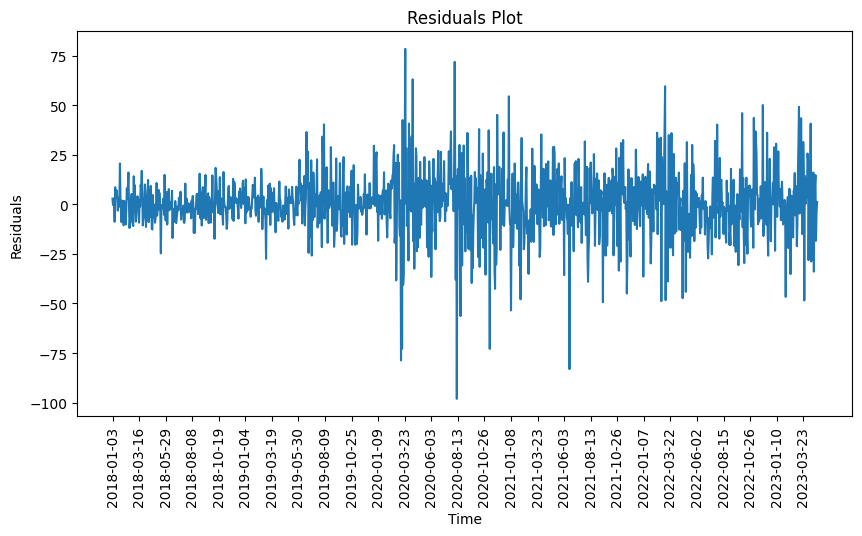

<Figure size 1000x500 with 0 Axes>

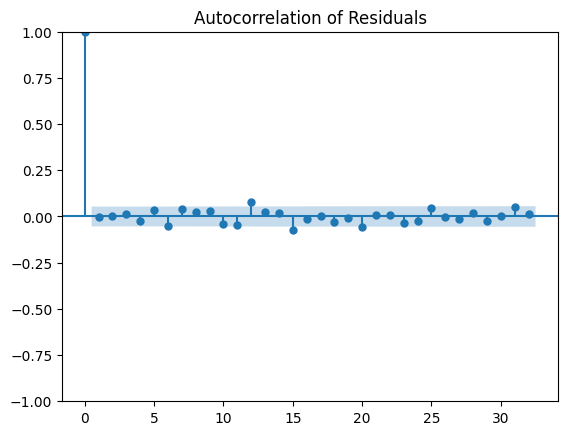

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

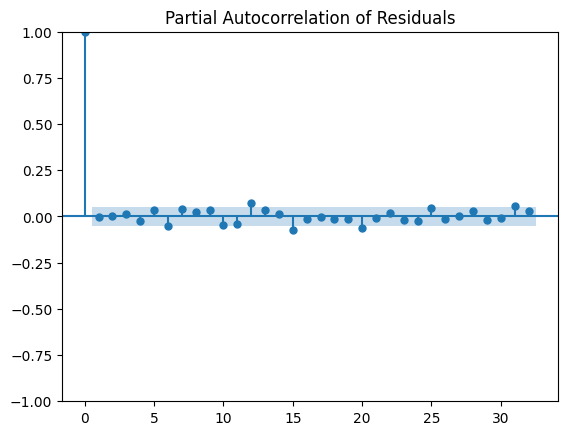

Residuals do not follow a normal distribution.


In [ ]:
# 残差分析
residuals = model.resid[1:]

# 绘制残差图
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.xlabel('Time')
plt.xticks(range(0, len(prices), 50), rotation=90)
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# 绘制残差的自相关图（ACF）和偏自相关图（PACF）
plt.figure(figsize=(10,5))
plot_acf(residuals)
plt.title('Autocorrelation of Residuals')
plt.show()

plt.figure(figsize=(10,5))
plot_pacf(residuals)
plt.title('Partial Autocorrelation of Residuals')
plt.show()

# 正态性检验
from scipy.stats import normaltest
_, p_value = normaltest(residuals)
if p_value < 0.05:
    print("Residuals do not follow a normal distribution.")
else:
    print("Residuals follow a normal distribution.")

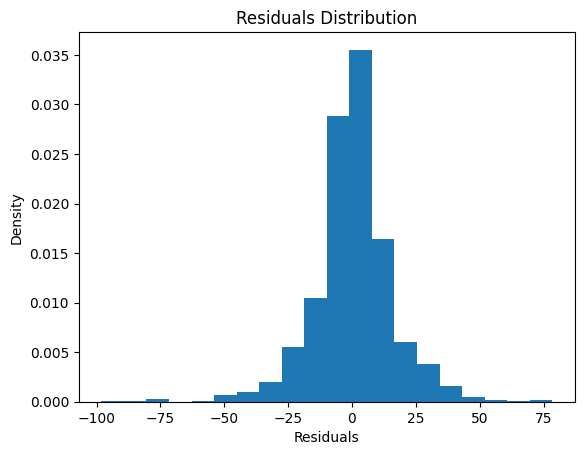

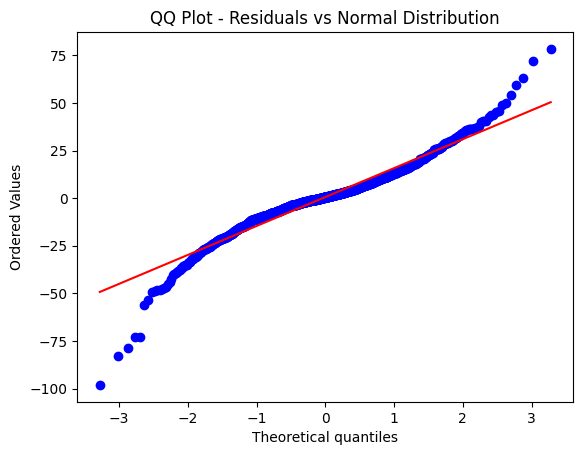

Residuals Skewness: -0.37677274406104333
Residuals Kurtosis: 4.420244119354261


In [ ]:
import scipy.stats as stats

# 残差分布图
# plt.figure(figsize=(10,5))
plt.hist(residuals, bins=20, density=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals Distribution')
plt.show()

# 残差的QQ图
# plt.figure(figsize=(10,5))
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('QQ Plot - Residuals vs Normal Distribution')
plt.show()

# 计算残差的偏度和峰度
residuals_skewness = stats.skew(residuals)
residuals_kurtosis = stats.kurtosis(residuals)

print(f"Residuals Skewness: {residuals_skewness}")
print(f"Residuals Kurtosis: {residuals_kurtosis}")


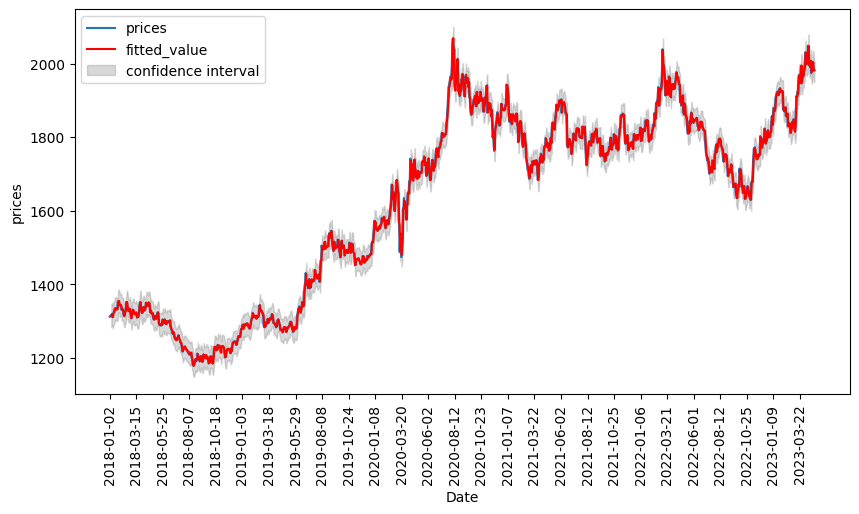

In [ ]:
# 获取拟合值和置信区间
pred = model.get_prediction(start='2018-01-05', end='2023-05-01')
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

# 绘制拟合值和置信区间
plt.figure(figsize=(10, 5))
plt.plot(prices.index, prices.values, label='prices')
plt.plot(pred_mean.index, pred_mean.values, color='red', label='fitted_value')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='confidence interval')
plt.xlabel('Date')
plt.xticks(range(0, len(prices), 50), rotation=90)
plt.ylabel('prices')
plt.legend()
plt.show()

In [ ]:
from arch import arch_model

# 建立ARCH(1,1)模型
model_garch = arch_model(residuals, vol='ARCH', p=1, q=1, mean='Zero', lags=1)
model_garch_fit = model_garch.fit()

# 输出模型结果
print(model_garch_fit.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: 5579.733901979203
Iteration:      2,   Func. Count:      9,   Neg. LLF: 5518.061764752783
Iteration:      3,   Func. Count:     12,   Neg. LLF: 5518.061496683322
Iteration:      4,   Func. Count:     15,   Neg. LLF: 5518.061084495865
Iteration:      5,   Func. Count:     18,   Neg. LLF: 5518.059876300853
Iteration:      6,   Func. Count:     21,   Neg. LLF: 5518.05753302704
Iteration:      7,   Func. Count:     24,   Neg. LLF: 5518.054643581971
Iteration:      8,   Func. Count:     27,   Neg. LLF: 5518.052627840261
Iteration:      9,   Func. Count:     30,   Neg. LLF: 5518.052101688363
Iteration:     10,   Func. Count:     33,   Neg. LLF: 5518.052059904545
Iteration:     11,   Func. Count:     36,   Neg. LLF: 5518.052059330256
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5518.052059330256
            Iterations: 11
            Function evaluations: 36
            Gradient evaluations: 11


In [ ]:
# 进行未来价格的预测
forecast_steps = 15  # 预测步数
forecasts = model.get_forecast(steps=len(test), alpha=0.05)
confidence = forecasts.conf_int()
forecast = forecasts.predicted_mean
# 将预测结果与实际价格进行比较
actual_prices = test['price']  # 获取测试集中前几个实际价格数据

# 打印预测结果和实际价格
print("置信区间")
print(confidence)
print("预测结果：")
print(forecast)
print("实际价格：")
print(actual_prices)

置信区间
      lower price  upper price
1328  1950.839919  2012.213423
1329  1938.489451  2024.010737
1330  1928.670530  2034.176475
1331  1921.223692  2042.500500
1332  1915.438333  2049.220973
1333  1910.664647  2054.655396
1334  1906.377399  2059.196103
1335  1902.243814  2063.223121
1336  1898.111777  2067.041405
1337  1893.963859  2070.841154
1338  1889.860195  2074.690402
1339  1885.882540  2078.562395
1340  1882.091463  2082.383711
1341  1878.506423  2086.080550
1342  1875.108837  2089.607420
1343  1871.858812  2092.955092
1344  1868.713860  2096.143529
1345  1865.641799  2099.207911
1346  1862.625532  2102.184548
1347  1859.661247  2105.100952
1348  1856.753077  2107.971760
1349  1853.907195  2110.799935
1350  1851.127449  2113.581186
1351  1848.413474  2116.309128
1352  1845.761055  2118.979232
1353  1843.163830  2121.590710
1354  1840.615250  2124.146437
1355  1838.110018  2126.651619
1356  1835.644666  2129.112081
预测结果：
1328    1981.526671
1329    1981.250094
1330    1981.423503

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


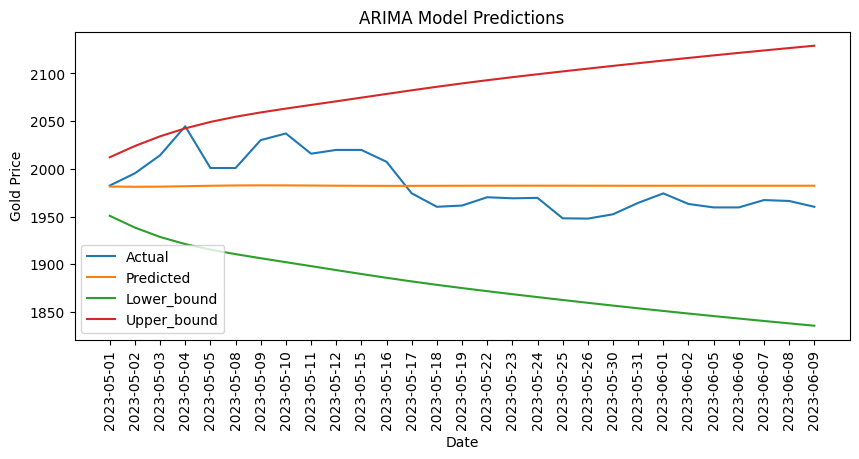

In [ ]:
# 绘制预测值和置信区间
plt.figure(figsize=(10, 4))
plt.plot(test.index, test['price'], label='Actual')
plt.plot(test.index, forecast, label='Predicted')
plt.plot(test.index, confidence['lower price'], label='Lower_bound')
plt.plot(test.index, confidence['upper price'], label='Upper_bound')

# 添加标签和图例
plt.xlabel('Date')
plt.xticks(range(0, len(test['price']), 1), rotation=90)
plt.ylabel('Gold Price')
plt.title('ARIMA Model Predictions')
plt.legend()

# 显示图形
plt.show()

## 时间序列回归模型

In [ ]:
# 选取建模所需的数据，调整不同的指标可以选择不同时间长度的数据来进行建模
dataTS = data.loc['2018-01-01':'2023-06-12', ['price', 'rate', 'oilprice', 'VIX', 'spread', 'ratio']]

# 拟合ARIMA模型
# model_arima = ARIMA(dataTS['price'], order=(3, 1, 2))  # 替换为合适的p, d, q值
# model_fit = model_arima.fit()
# print(model_fit.summary())

In [ ]:
# 划分训练集和测试集
train_data = dataTS.loc['2018-01-01':'2023-04-30', ['price', 'rate', 'oilprice', 'VIX', 'spread', 'ratio']]
test_data = dataTS.loc['2023-05-01':'2023-06-12', ['price', 'rate', 'oilprice', 'VIX', 'spread', 'ratio']]

# 拟合ARIMA模型
model_arima = ARIMA(train_data['price'], order=(3, 1, 2))  # 替换为合适的p, d, q值
model_fit = model_arima.fit()
print(model_fit.summary())

# 提取外生变量的训练数据
# train_exog = train_data[['rate', 'oilprice', 'VIX']]

# # 构建时间序列回归模型
# model_arimax = sm.tsa.ARIMA(train_data['price'], exog=train_exog, order=(3, 1, 3))
# model_arimax_fit = model_arimax.fit()
# print(model_arimax_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1327
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5529.737
Date:                Mon, 19 Jun 2023   AIC                          11071.475
Time:                        01:33:29   BIC                          11102.614
Sample:                             0   HQIC                         11083.147
                               - 1327                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2037      0.151      7.973      0.000       0.908       1.500
ar.L2         -0.4945      0.142     -3.493      0.000      -0.772      -0.217
ar.L3         -0.0908      0.022     -4.149      0.0

In [ ]:
# 提取外生变量的训练数据
train_exog = train_data[['rate', 'oilprice', 'VIX']]

# 构建时间序列回归模型
model_arimax = sm.tsa.ARIMA(train_data['price'], exog=train_exog, order=(3, 1, 3))
model_arimax_fit = model_arimax.fit()
print(model_arimax_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1327
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5467.110
Date:                Mon, 19 Jun 2023   AIC                          10954.220
Time:                        01:33:42   BIC                          11006.119
Sample:                             0   HQIC                         10973.674
                               - 1327                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
rate         -77.1849      5.476    -14.094      0.000     -87.918     -66.451
oilprice       0.6801      0.203      3.344      0.001       0.281       1.079
VIX           -0.3129      0.108     -2.896      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


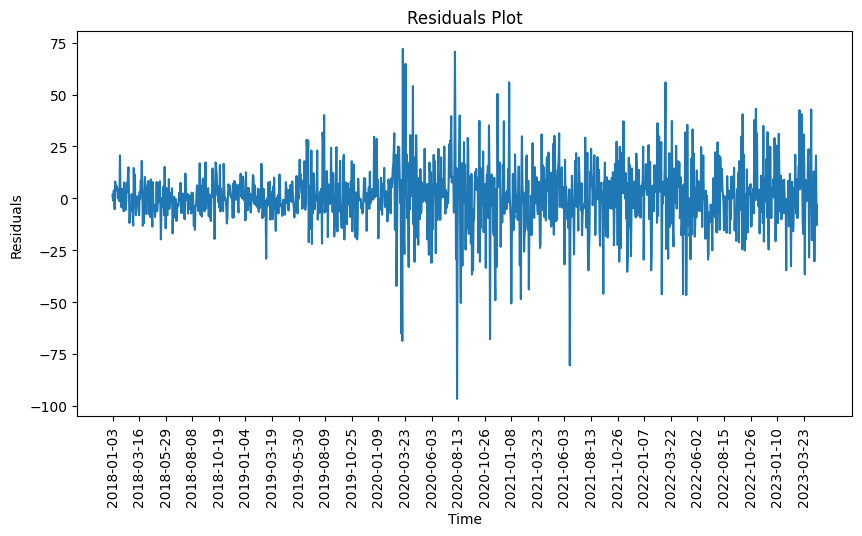

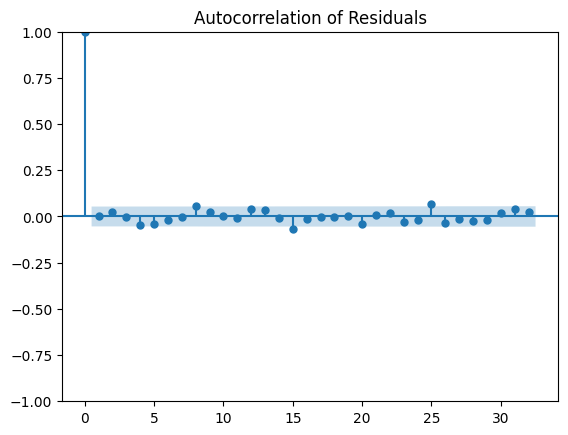

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


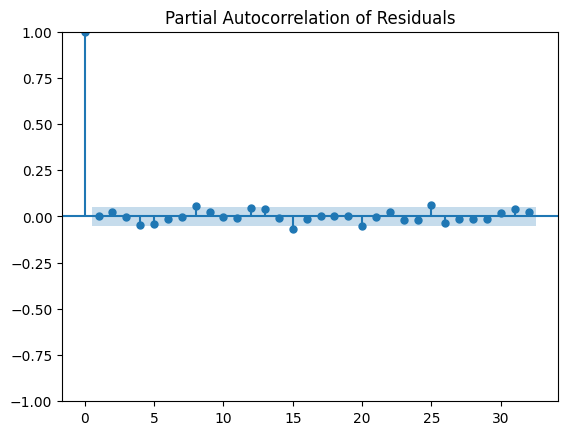

Residuals do not follow a normal distribution.


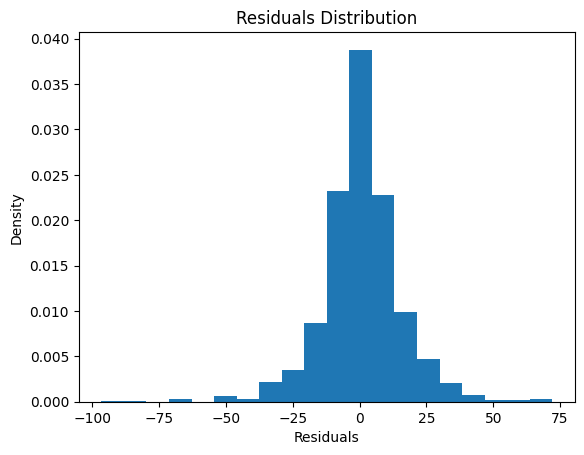

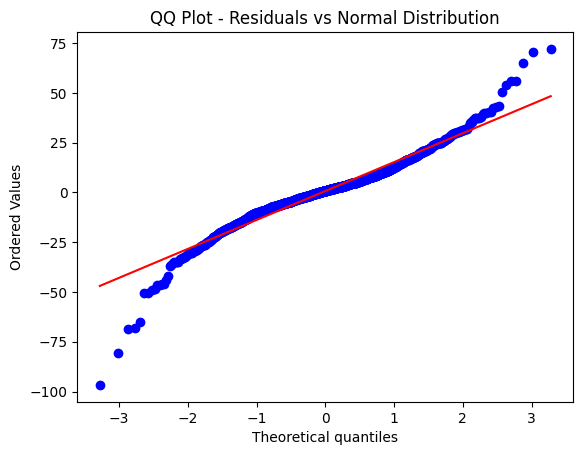

Residuals Skewness: -0.309297873882545
Residuals Kurtosis: 4.4072235729731


In [ ]:
# 残差分析
residuals = model_arimax_fit.resid[1:]

# 绘制残差图
plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.xlabel('Time')
plt.xticks(range(0, len(train_data['price']), 50), rotation=90)
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# 绘制残差的自相关图（ACF）和偏自相关图（PACF）
plot_acf(residuals)
plt.title('Autocorrelation of Residuals')
plt.show()

plot_pacf(residuals)
plt.title('Partial Autocorrelation of Residuals')
plt.show()

# 正态性检验
from scipy.stats import normaltest
_, p_value = normaltest(residuals)
if p_value < 0.05:
    print("Residuals do not follow a normal distribution.")
else:
    print("Residuals follow a normal distribution.")

# 残差分布图
plt.hist(residuals, bins=20, density=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals Distribution')
plt.show()

# 残差的QQ图
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('QQ Plot - Residuals vs Normal Distribution')
plt.show()

# 计算残差的偏度和峰度
residuals_skewness = stats.skew(residuals)
residuals_kurtosis = stats.kurtosis(residuals)

print(f"Residuals Skewness: {residuals_skewness}")
print(f"Residuals Kurtosis: {residuals_kurtosis}")

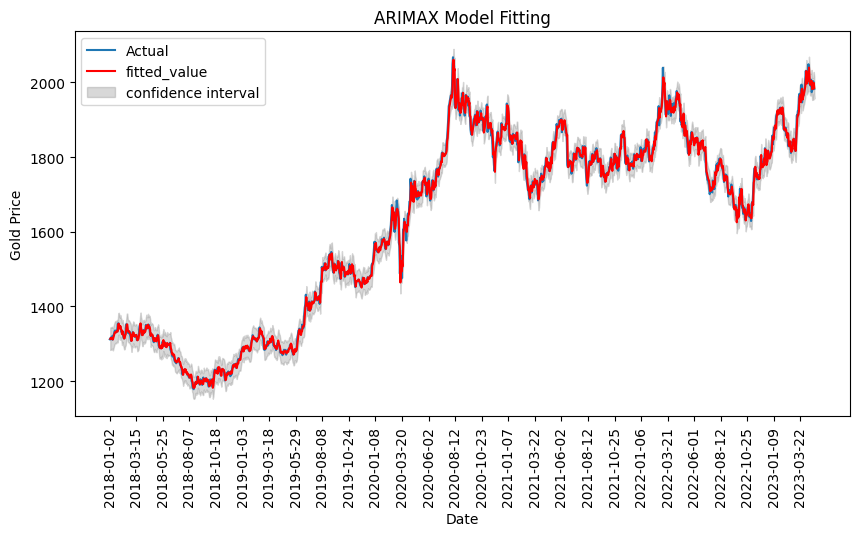

In [ ]:
# 提取拟合值和置信区间的相关信息
fitting = model_arimax_fit.get_prediction(start=1, end=len(train_data['price'])-1, exog=train_exog)
fitted = fitting.predicted_mean
confidence_interval = fitting.conf_int()


# 绘制拟合值、置信区间和实际值的图形
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data['price'], label='Actual')
plt.plot(fitted.index, fitted, color='red', label='fitted_value')
plt.fill_between(confidence_interval.index, confidence_interval['lower price'], confidence_interval['upper price'], color='gray', alpha=0.3, label='confidence interval')

# 添加标签和图例
plt.xlabel('Date')
plt.xticks(range(0, len(train_data['price']), 50), rotation=90)
plt.ylabel('Gold Price')
plt.title('ARIMAX Model Fitting')
plt.legend()

# 显示图形
plt.show()

In [ ]:
# 预测未来的黄金价格
test_exog = test_data[['rate', 'oilprice', 'VIX']]
forecast = model_arimax_fit.get_forecast(steps=len(test_data), exog=test_exog, alpha=0.05)
confidence = forecast.conf_int()
predictions = forecast.predicted_mean
print(confidence)
print(predictions)
print(test_data['price'])

      lower price  upper price
1327  1948.058037  2006.615945
1328  1940.819539  2019.914551
1329  1937.811162  2032.753190
1330  1929.514227  2037.761778
1331  1923.889618  2042.598873
1332  1915.475487  2044.621193
1333  1909.602839  2047.138449
1334  1909.792504  2055.852441
1335  1906.064881  2059.622604
1336  1898.986403  2059.706956
1337  1893.403533  2061.088248
1338  1886.521654  2060.507157
1339  1885.367637  2065.800540
1340  1876.085738  2062.347612
1341  1870.381675  2062.547518
1342  1865.402447  2063.138159
1343  1867.012469  2070.169006
1344  1860.971645  2069.487988
1345  1849.598288  2063.183227
1346  1849.098805  2067.800065
1347  1851.939596  2075.485225
1348  1849.376023  2077.766992
1349  1849.628479  2082.711763
1350  1844.715838  2082.393007
1351  1843.179065  2085.408332
1352  1840.880825  2087.506670
1353  1833.107357  2084.127893
1354  1833.862089  2089.136313
1355  1830.037410  2089.538379
1327    1977.336991
1328    1980.367045
1329    1985.282176
1330    19

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


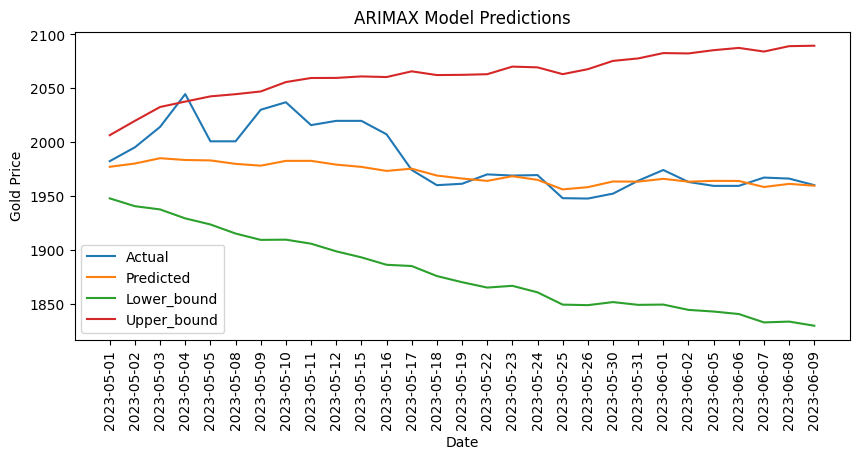

In [ ]:
# 绘制预测值和置信区间
plt.figure(figsize=(10, 4))
plt.plot(test_data.index, test_data['price'], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.plot(test_data.index, confidence['lower price'], label='Lower_bound')
plt.plot(test_data.index, confidence['upper price'], label='Upper_bound')

# 添加标签和图例
plt.xlabel('Date')
plt.xticks(range(0, len(test_data['price']), 1), rotation=90)
plt.ylabel('Gold Price')
plt.title('ARIMAX Model Predictions')
plt.legend()

# 显示图形
plt.show()

## 回归预测模型

In [ ]:
# 选取建模所需的数据，调整不同的指标可以选择不同时间长度的数据来进行建模
data = data.loc['2013-01-01':'2023-04-30', ['price', 'rate', 'oilprice', 'VIX']]
# 2022年至今的各项数据结果
data_pre = data.loc['2023-05-01':'2023-06-12', ['price', 'rate', 'oilprice', 'VIX']]

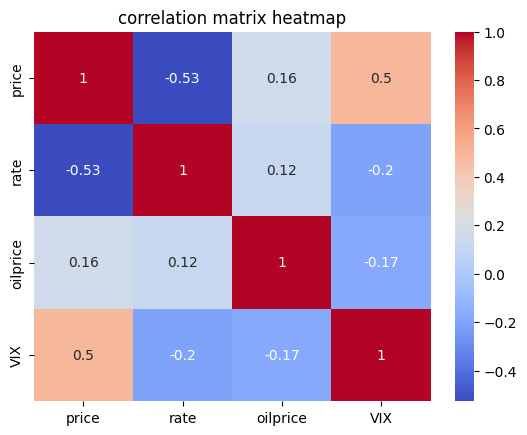

In [ ]:
# 计算数据之间的相关性系数
corr_matrix = data.corr()

# 绘制热力图
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('correlation matrix heatmap')
plt.savefig('heat.png', bbox_inches='tight')
plt.show()

In [ ]:
# 定义自变量和因变量
X = data[['rate', 'oilprice', 'VIX', 'spread', 'ratio']]
Y = data['price']
X_pre = data_pre[['rate', 'oilprice', 'VIX', 'spread', 'ratio']]
Y_pre = data_pre['price']

# 划分数据集为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(X_pre)

Empty DataFrame
Columns: [rate, oilprice, VIX, spread, ratio]
Index: []


In [ ]:
# 岭回归模型拟合数据
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, Y_train)

# 使用测试数据进行预测并评估模型的性能
# Y_ridge_pred = ridge_model.predict(X_test)

# 在数据集上进行预测
Y_test_pred = ridge_model.predict(X_test)
Y_train_pred = ridge_model.predict(X_train)
# 计算训练集和测试集上的均方误差
train_error = mean_squared_error(Y_train, Y_train_pred)
test_error = mean_squared_error(Y_test, Y_test_pred)

print("训练集上的均方误差：", train_error)
print("测试集上的均方误差：", test_error)

# 使用交叉验证评估模型性能
scores = cross_val_score(ridge_model, X_test, Y_test, cv=5, scoring='neg_mean_squared_error')

# 计算均方误差的平均值
mean_score = -scores.mean()

print("交叉验证测试集均方误差：", mean_score)

# 在Y_pre上评估模型性能
ridge_pred = ridge_model.predict(X_pre)
mse = mean_squared_error(Y_pre, ridge_pred)
r2 = r2_score(Y_pre, ridge_pred)
print(mse, r2)

训练集上的均方误差： 12486.550361959748
测试集上的均方误差： 14730.197114072134
交叉验证测试集均方误差： 14956.589008051942


ValueError: ignored

In [ ]:
# 打印回归系数和p值
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_sm)
ridgeresults = model.fit()
print(ridgeresults.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1887.
Date:                Sat, 10 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:26:49   Log-Likelihood:                -12664.
No. Observations:                2062   AIC:                         2.534e+04
Df Residuals:                    2056   BIC:                         2.537e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1676.4597     36.247     46.250      0.0

In [ ]:
# 根据summary中的回归系数计算预测值
X2022_sm = sm.add_constant(X2022)
pred = ridgeresults.get_prediction(X2022_sm)

# 获取预测结果的置信区间
ridge_pred_conf_int = pred.summary_frame(alpha=0.05)

# 计算预测值的最大值和最小值
ridge_pred_min = ridge_pred_conf_int['mean_ci_lower']
ridge_pred_max = ridge_pred_conf_int['mean_ci_upper']

In [ ]:
# 多项式回归模型
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X2022_poly = poly.fit_transform(X2022)
X_train_poly = poly.fit_transform(X_train)  # 训练集多项式特征转换
X_test_poly = poly.transform(X_test)  # 测试集多项式特征转换

# 训练模型和预测
polymodel = LinearRegression()
polymodel.fit(X_train_poly, Y_train)

# 在数据集上进行预测
Y_poly_pred = polymodel.predict(X_test_poly)
Y_train_pred = polymodel.predict(X_train_poly)
# 计算训练集和测试集上的均方误差
train_error = mean_squared_error(Y_train, Y_train_pred)
test_error = mean_squared_error(Y_test, Y_poly_pred)

print("训练集上的均方误差：", train_error)
print("测试集上的均方误差：", test_error)

# 创建多项式回归模型的Pipeline
poly_regression = make_pipeline(poly, polymodel)

# 使用交叉验证评估模型性能
scores = cross_val_score(poly_regression, X_test, Y_test, cv=5, scoring='neg_mean_squared_error')

# 计算均方误差的平均值
mean_score = -scores.mean()

print("交叉验证测试集均方误差：", mean_score)


# 在Y2022上评估模型性能
poly_pred = polymodel.predict(X2022_poly)
mse = mean_squared_error(Y2022, poly_pred)
r2 = r2_score(Y2022, poly_pred)
print(mse, r2)

训练集上的均方误差： 4884.169615548714
测试集上的均方误差： 5861.534257556601
交叉验证测试集均方误差： 7349.9713200158585
15582.680135171702 -0.5843336387962601


In [ ]:
# 打印回归系数和p值
X_train_poly_new = sm.add_constant(X_train_poly)
model = sm.OLS(Y_train, X_train_poly_new)
polyresults = model.fit()
print(polyresults.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1374.
Date:                Sat, 10 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:27:07   Log-Likelihood:                -11683.
No. Observations:                2062   AIC:                         2.341e+04
Df Residuals:                    2041   BIC:                         2.353e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1745.3081    139.335     12.526      0.0

In [ ]:
# 根据summary中的回归系数计算预测值
X2022_poly_sm = sm.add_constant(X2022_poly)
pred = polyresults.get_prediction(X2022_poly_sm)

# 获取预测结果的置信区间
poly_pred_conf_int = pred.summary_frame(alpha=0.05)

# 计算预测值的最大值和最小值
poly_pred_min = poly_pred_conf_int['mean_ci_lower']
poly_pred_max = poly_pred_conf_int['mean_ci_upper']

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 创建随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10)

# 在训练集上拟合模型
rf_model.fit(X_train, Y_train)

# 在数据集上进行预测
Y_rf_test_pred = rf_model.predict(X_test)
Y_rf_train_pred = rf_model.predict(X_train)
# 计算训练集和测试集上的均方误差
train_error = mean_squared_error(Y_train, Y_rf_train_pred)
test_error = mean_squared_error(Y_test, Y_rf_test_pred)

print("训练集上的均方误差：", train_error)
print("测试集上的均方误差：", test_error)

# 使用交叉验证评估模型性能
scores = cross_val_score(rf_model, X_test, Y_test, cv=5, scoring='neg_mean_squared_error')

# 计算均方误差的平均值
mean_score = -scores.mean()

print("交叉验证测试集均方误差：", mean_score)

# 获取特征重要性
feature_importances = rf_model.feature_importances_

# 将特征重要性与特征名对应起来，并打印
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print(feature_importances_df)

# 在测试集上进行预测
rf_pred = rf_model.predict(X2022)

# 在Y2022上评估模型性能
mse = mean_squared_error(Y2022, rf_pred)
r2 = r2_score(Y2022, rf_pred)
print(mse, r2)

训练集上的均方误差： 1773.840244349459
测试集上的均方误差： 2223.652699623733
交叉验证测试集均方误差： 5211.305760897221
    Feature  Importance
0      rate    0.553504
1  oilprice    0.057262
2       VIX    0.008723
3    spread    0.303325
4     ratio    0.077186
3124.5834125468014 0.6823150725818218


In [ ]:
result = pd.DataFrame(Y2022)
result = result.reset_index()
result['ridge_pred'] = pd.DataFrame(ridge_pred)
result['poly_pred'] = pd.DataFrame(poly_pred)
result['rf_pred'] = pd.DataFrame(rf_pred)

<ipython-input-75-52369d7fb348>:16: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig('ridge.png', bbox_inches='tight')
<ipython-input-75-52369d7fb348>:16: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig('ridge.png', bbox_inches='tight')
<ipython-input-75-52369d7fb348>:16: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from current font.
  plt.savefig('ridge.png', bbox_inches='tight')
<ipython-input-75-52369d7fb348>:16: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig('ridge.png', bbox_inches='tight')
<ipython-input-75-52369d7fb348>:16: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.savefig('ridge.png', bbox_inches='tight')
<ipython-input-75-52369d7fb348>:16: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  plt.savefig('ridge.png', bbox_in

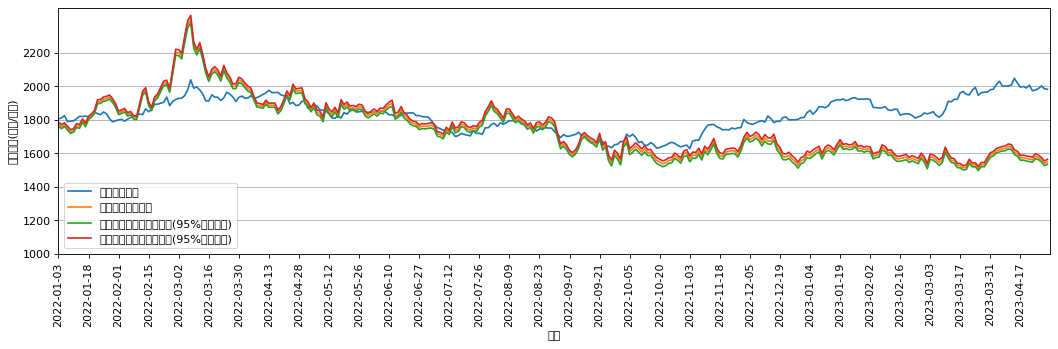

In [ ]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(result['Date'], result['price'], label=u'黄金实际价格')
plt.plot(result['Date'], result['ridge_pred'], label=u'岭回归模型预测值')
plt.plot(result['Date'], ridge_pred_min, label=u'岭回归模型预测值最小值(95%置信区间)')
plt.plot(result['Date'], ridge_pred_max, label=u'岭回归模型预测值最大值(95%置信区间)')

plt.xlabel('日期')
plt.ylabel('黄金价格(美元/盎司)')
plt.xticks(range(0, len(result['price']), 10), rotation=90)
plt.yticks(range(1000, 2400, 200))
plt.xlim(0,len(result['price']))
plt.grid(axis='y')
plt.legend()

plt.savefig('ridge.png', bbox_inches='tight')
plt.show()

<ipython-input-76-31e6687cbea0>:17: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig('poly.png', bbox_inches='tight')
<ipython-input-76-31e6687cbea0>:17: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig('poly.png', bbox_inches='tight')
<ipython-input-76-31e6687cbea0>:17: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from current font.
  plt.savefig('poly.png', bbox_inches='tight')
<ipython-input-76-31e6687cbea0>:17: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig('poly.png', bbox_inches='tight')
<ipython-input-76-31e6687cbea0>:17: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.savefig('poly.png', bbox_inches='tight')
<ipython-input-76-31e6687cbea0>:17: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  plt.savefig('poly.png', bbox_inches='

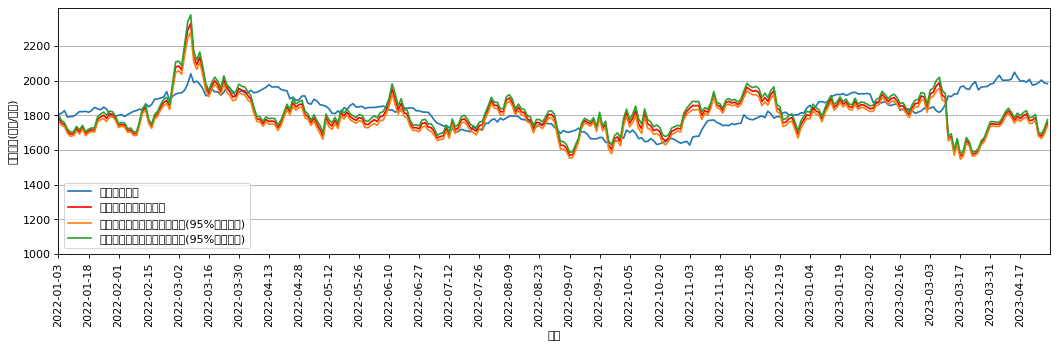

In [ ]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(result['Date'], result['price'], label=u'黄金实际价格')
plt.plot(result['Date'], result['poly_pred'], color='red', label=u'多项式回归模型预测值')
plt.plot(result['Date'], poly_pred_min, label=u'多项式回归模型预测值最小值(95%置信区间)')
plt.plot(result['Date'], poly_pred_max, label=u'多项式回归模型预测值最大值(95%置信区间)')


plt.xlabel('日期')
plt.ylabel('黄金价格(美元/盎司)')
plt.xticks(range(0, len(result['price']), 10), rotation=90)
plt.yticks(range(1000, 2400, 200))
plt.xlim(0,len(result['price']))
plt.grid(axis='y')
plt.legend()

plt.savefig('poly.png', bbox_inches='tight')
plt.show()

In [ ]:
!wget -O simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')
font_path = 'simhei.ttf'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

--2023-06-10 10:36:57--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3031::ac43:813a, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  23.2MB/s    in 0.4s    

2023-06-10 10:36:58 (23.2 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



NameError: ignored

<ipython-input-82-150aec5dcbe6>:16: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig('rf.png', bbox_inches='tight')
<ipython-input-82-150aec5dcbe6>:16: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig('rf.png', bbox_inches='tight')
<ipython-input-82-150aec5dcbe6>:16: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from current font.
  plt.savefig('rf.png', bbox_inches='tight')
<ipython-input-82-150aec5dcbe6>:16: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.savefig('rf.png', bbox_inches='tight')
<ipython-input-82-150aec5dcbe6>:16: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.savefig('rf.png', bbox_inches='tight')
<ipython-input-82-150aec5dcbe6>:16: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  plt.savefig('rf.png', bbox_inches='tight')
<ipy

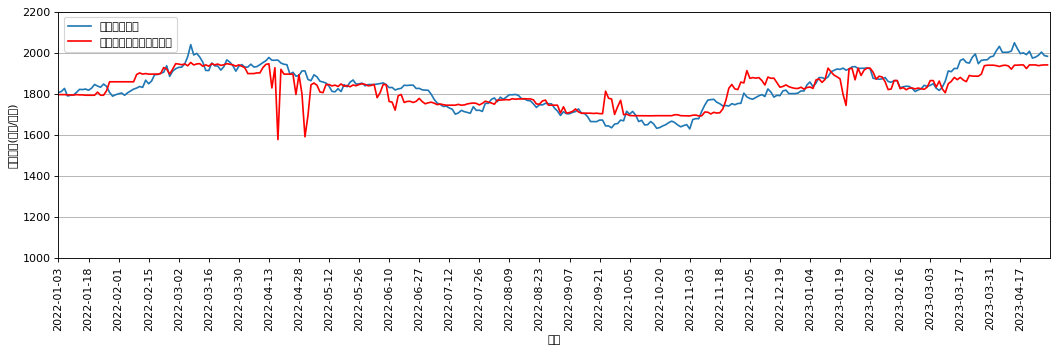

In [ ]:
# plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
# plt.rcParams['font.sans-serif'] = 'SimSun'
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(result['Date'], result['price'], label=u'黄金实际价格')
plt.plot(result['Date'], result['rf_pred'], color='red', label=u'随机森林回归模型预测值')


plt.xlabel('日期')
plt.ylabel('黄金价格(美元/盎司)')
plt.xticks(range(0, len(result['price']), 10), rotation=90)
plt.yticks(range(1000, 2400, 200))
plt.xlim(0,len(result['price']))
plt.grid(axis='y')
plt.legend()

plt.savefig('rf.png', bbox_inches='tight')
plt.show()

In [ ]:
# 选取提前N天的数据集进行预测。
X.drop(X.tail(10).index, inplace=True)
Y = Y.iloc[10:]
X_pre_poly = poly.fit_transform(X)
pre_pred = polymodel.predict(X_pre_poly)

r2 = r2_score(Y, pre_pred)

print('R2 Score:', r2)

R2 Score: 0.9319085046551951


D:\anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
